# RAG with GRPO Fine-Tuned Reasoning Model
* https://blog.lancedb.com/grpo-understanding-and-fine-tuning-the-next-gen-reasoning-model-2/

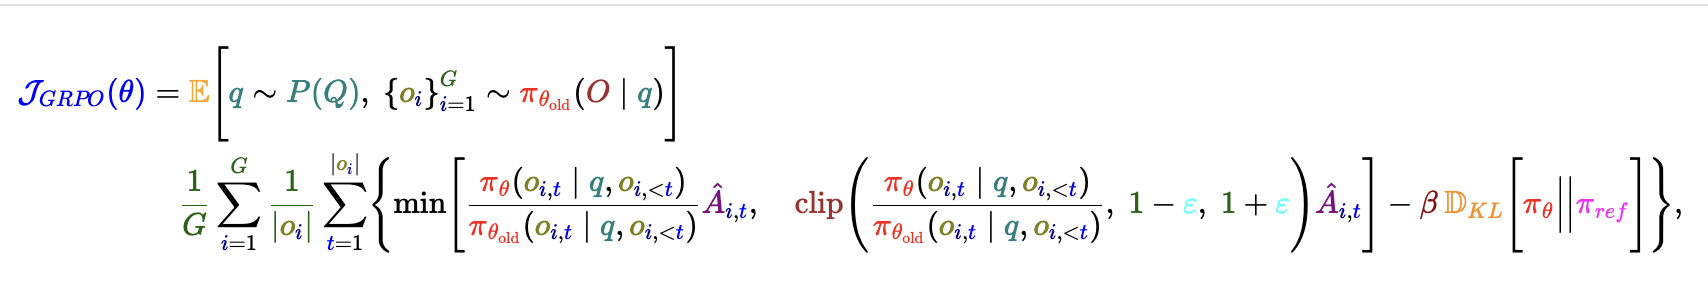

* Overall Objective (𝒥GRPO(θ)): This is the GRPO Loss function we need to improve our model. Each components of this loss are defined below.

* Question Sampling (q ∼ P(Q)): A question (AKA PROMPT) is randomly chosen from a pool of questions. This represents the problem or prompt that the model needs to answer.

* Group of Outputs ({Oi} with G outputs): For each question, we generate several answers (G in total, GRPOTrainer uses 8 by default) using the model from the previous training step. These outputs are like multiple attempts at answering the same question. This is the Crux of the equation because we don't have a Ground truth so we rate THESE answers based on some pre defined function and compute the score for EACH of the Answer and then see if an answer is above or below Average score of group: `self.sampling_params = SamplingParams(n=args.num_generations)`

* Reference Policy (πref): This is the model that we fine-tuned using SFT. It serves as a base to ensure that the model’s updates do start giving weird answers.
`self.ref_model = AutoModelForCausalLM.from_pretrained(model_id, **model_init_kwargs)`

* Current Policy (πθ): This is the model we are actively training and updating. During output generation, we compare how the current policy behaves relative to the old policy "LOGIT by LOGIT"Loss is computed Logit vise
`model = AutoModelForCausalLM.from_pretrained(model, **model_init_kwargs)`

* Old Policy (πθ_old): Same model as above BUT this is the version of from the previous epoch. It also has "G" answers to the Prompts but for the "PREVIOUS" epoch

* Token Advantage (ĤAi,t): This term represents the normalized reward (or advantage) associated with "EACH TOKEN". It indicates how much better or worse the generation related to Z score. One thing is that score is Given for final Generation BUT it is replicated as same for EACH Logit in the answer. `advantages = (rewards - mean_grouped_rewards) / (std_grouped_rewards + 1e-4)`


* Clipping Range (1 – ε to 1 + ε): The ratio between the current and old policies is clipped within this range to prevent large, unstable updates. This ensures that each update is moderate and controlled.
`torch.clamp(coef_1, 1 - self.epsilon, 1 + self.epsilon)`

* KL Divergence Penalty (𝔻KL[πθ || πref]): This term measures the difference between the current policy and the reference policy. By penalizing large differences, it helps keep the updated model close to the original fine-tuned model, ensuring that improvements are made without losing previously learned skills. It is also implemented PER TOKEN
`per_token_kl = (torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1)`

* Ref:  https://huggingface.co/docs/trl/main/en/grpo_trainer

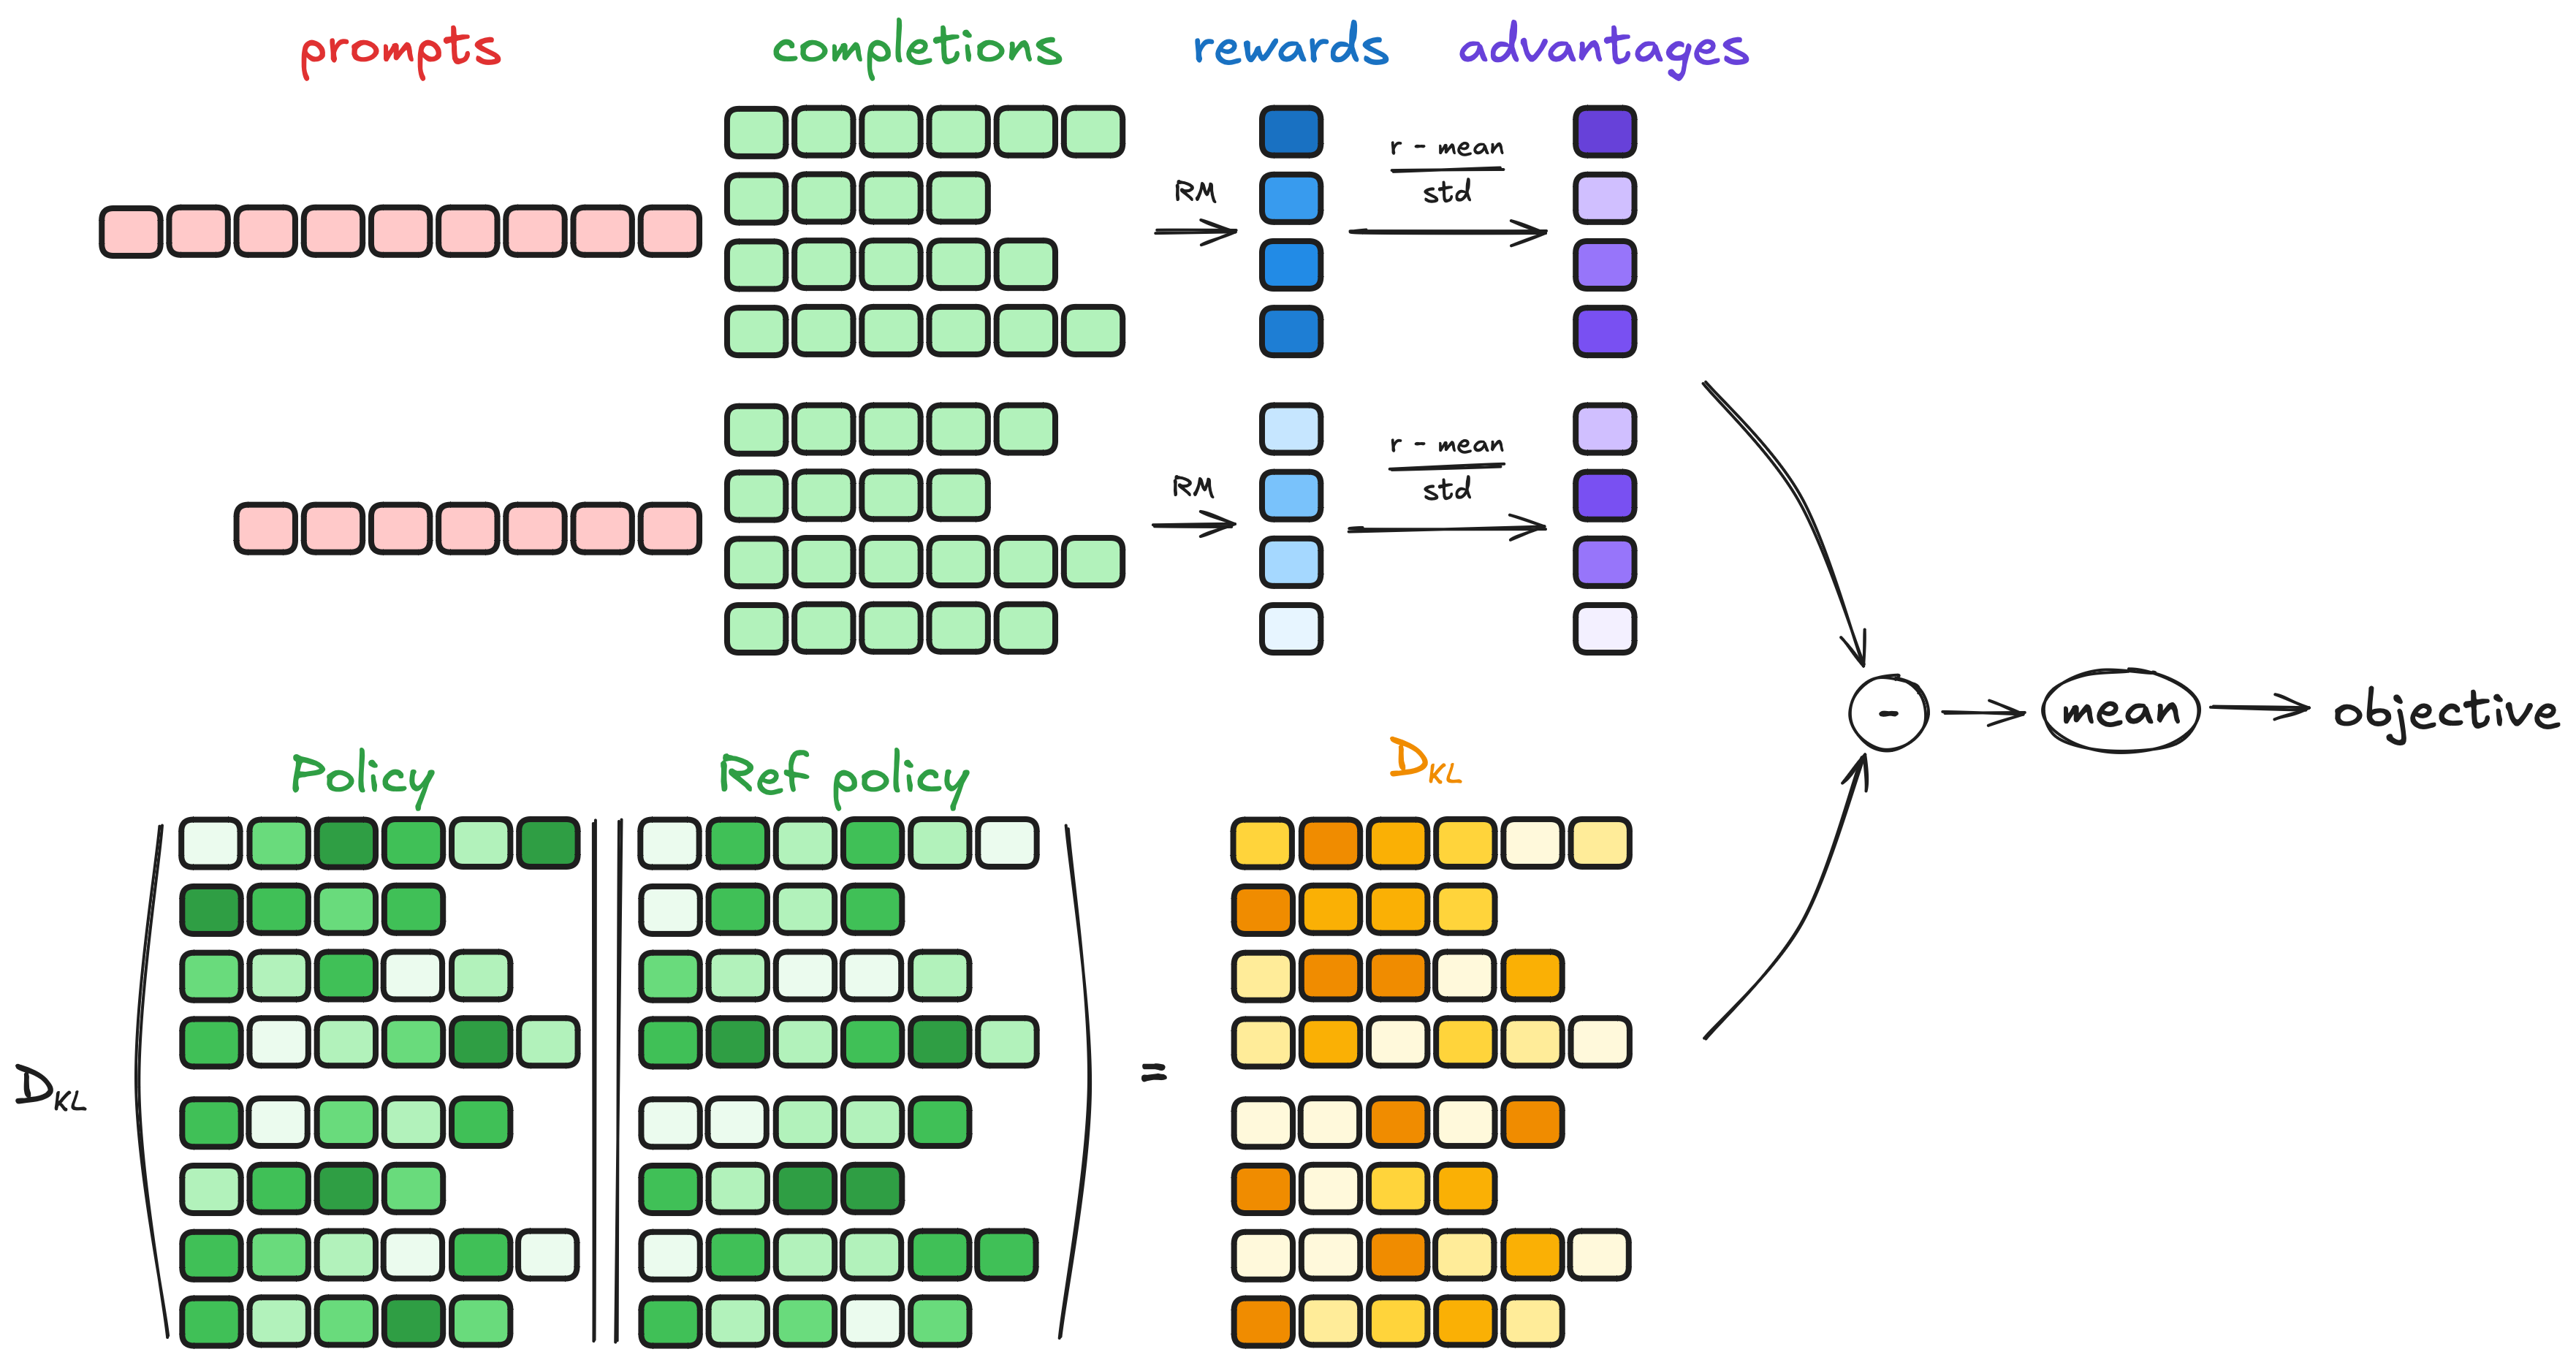

# Fine tune a model on GRPO

In [2]:
!pip install -qqq unsloth vllm --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gptqmodel 1.9.0 requires device-smi==0.3.3, but you have device-smi 0.4.0 which is incompatible.
gptqmodel 1.9.0 requires protobuf>=5.29.3, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
llama-cloud-services 0.6.12 requires platformdirs<5.0.0,>=4.3.7, but you have platformdirs 4.3.6 which is incompatible.


In [8]:
import torch
import re
from datasets import load_dataset, Dataset
from trl import GRPOConfig, GRPOTrainer
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer

2025-07-15 20:05:56.316908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752627956.329513  125045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752627956.333330  125045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752627956.343937  125045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752627956.343954  125045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752627956.343956  125045 computation_placer.cc:177] computation placer alr

INFO 07-15 20:05:58 [__init__.py:244] Automatically detected platform cuda.


# If the version of torch and flash-attn are not compatiable, then

In [ ]:
pip show torch


Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /home/dada/anaconda3/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, bitsandbytes, compressed-tensors, cut-cross-entropy, flash_attn, gptqmodel, neuralforecast, optimum, outlines, peft, pytorch-lightning, pytorch-tabnet, sentence-transformers, torchaudio, torchmetrics, torchvision, unsloth, unsloth_zoo, vllm, xformers, xgrammar
Note: you may need to restart the kernel to

In [4]:
pip show flash-attn

Name: flash_attn
Version: 2.7.4.post1
Summary: Flash Attention: Fast and Memory-Efficient Exact Attention
Home-page: https://github.com/Dao-AILab/flash-attention
Author: Tri Dao
Author-email: tri@tridao.me
License: 
Location: /home/dada/anaconda3/lib/python3.12/site-packages
Requires: einops, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Uninstall flash-attn and then reinstall it, making sure to use the correct CUDA and PyTorch versions as specified by its documentation. 

In [1]:
%pip uninstall flash-attn -y
%pip install flash-attn --no-cache-dir --force-reinstall -q # add --no-cache-dir and --force-reinstall as needed

Found existing installation: flash_attn 2.7.4.post1
Uninstalling flash_attn-2.7.4.post1:
  Successfully uninstalled flash_attn-2.7.4.post1
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 4.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 65.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 61.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 63.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 68.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.

In [9]:
import torch
import re
from datasets import load_dataset, Dataset
from trl import GRPOConfig, GRPOTrainer
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer

In [12]:
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 8 # Larger rank = smarter, but slower

In [10]:
# Load model
model_id = "HuggingFaceTB/SmolLM-135M-Instruct" # VERY Small model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
pip show gptqmodel #>2.0

Name: gptqmodel
Version: 1.9.0
Summary: A LLM quantization package with user-friendly apis. Based on GPTQ algorithm.
Home-page: https://github.com/ModelCloud/GPTQModel
Author: ModelCloud
Author-email: qubitium@modelcloud.ai
License: Apache 2.0
Location: /home/dada/anaconda3/lib/python3.12/site-packages
Requires: accelerate, datasets, device-smi, hf-transfer, huggingface-hub, numpy, packaging, pillow, protobuf, safetensors, threadpoolctl, tokenicer, torch, transformers
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [8]:
#pip install -v gptqmodel --no-build-isolation -U #Generalized Post-Training Quantization, layer based quantization for LLMs 

In [3]:
%pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 20.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
uv pip install -v gptqmodel --no-build-isolation -U

DEBUG uv 0.7.21
DEBUG Searching for default Python interpreter in virtual environments
DEBUG Found `cpython-3.12.7-linux-x86_64-gnu` at `/home/dada/anaconda3/bin/python` (parent interpreter)
DEBUG Allowing explicitly requested system Python interpreter at `/home/dada/anaconda3/bin/python`
Using Python 3.12.7 environment at: /home/dada/anaconda3
DEBUG Acquired lock for `/home/dada/anaconda3`
DEBUG Using request timeout of 30s
DEBUG Solving with installed Python version: 3.12.7
DEBUG Solving with target Python version: >=3.12.7
DEBUG Adding direct dependency: gptqmodel*
DEBUG No cache entry for: https://pypi.org/simple/gptqmodel/
DEBUG Found installed version of gptqmodel==1.9.0 that satisfies *
DEBUG Searching for a compatible version of gptqmodel (*)
DEBUG Found installed version of gptqmodel==1.9.0 that satisfies *
DEBUG Selecting: gptqmodel==2.2.0 [compatible] (gptqmodel-2.2.0.tar.gz)
DEBUG Acquired lock for `/home/dada/.cache/uv/sdists-v9/pypi/gptqmodel/2.2.0`
DEBUG No cache entry f

In [12]:
pip show gptqmodel

Name: gptqmodel
Version: 2.2.0
Summary: Production ready LLM model compression/quantization toolkit with hw accelerated inference support for both cpu/gpu via HF, vLLM, and SGLang.
Home-page: https://github.com/ModelCloud/GPTQModel
Author: ModelCloud
Author-email: qubitium@modelcloud.ai
License: Apache 2.0
Location: /home/dada/anaconda3/lib/python3.12/site-packages
Requires: accelerate, datasets, device-smi, hf_transfer, huggingface_hub, logbar, numpy, packaging, pillow, protobuf, random_word, safetensors, threadpoolctl, tokenicer, torch, transformers
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install logbar -q

  DEPRECATION: Building 'logbar' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'logbar'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gptqmodel 2.2.0 requires random_word==1.0.13, which is not installed.
gptqmodel 2.2.0 requires device-smi==0.4.1, but you have device-smi 0.4.0 which is incompatible.
gptqmodel 2.2.0 requires protobuf>=5.29.3, but you have protobuf 3.20.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Load LoRA
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    target_modules="all-linear",
)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())



INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          
trainable params: 2,442,240 || all params: 136,957,248 || trainable%: 1.7832
None


In [16]:
# Load dataset
dataset = load_dataset("mlabonne/smoltldr")
print(dataset)

README.md:   0%|          | 0.00/981 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
})


In [55]:
dataset["train"][0]

{'prompt': "SUBREDDIT: r/tifu\n\nTITLE: TIFU by trying to pet a dog.\n\nPOST: Last night I went to a Hippie May Day Festival/ Camp out. Needless to say, I passed out hard in my tent at the end of the night.Woken by the warmth and light of the morning sun, I emerged from my tent in search of some water to quench my burgeoning thirst. To my delight I spotted a dog scouting the field before me, about 110 meters away. Without delay I dashed towards it, my urge to pet this dog was immeasurable. On the way back to my tent, while running, I just so happened to come upon the most heinous stick I have ever encountered. The bastard was sticking straight out of the earth, cleverly hidden in a plush, verdant meadow. My foot never saw it coming. It had no warning, no shoe, no defense! The poor soul (no pun intended) never saw it coming, until the moment it was impaled by what I would have thought was the devils pitchfork itself. The worst part is, I didn't even get to pet the dog, it sprinted back 

# define reward functions

In [ ]:
def reward_len_50(completions, **kwargs):
    "Function to give rewards based on Length of the Answer as rule"
    return [-abs(50 - len(completion)) for completion in completions]

def reward_token_diversity(completions, **kwargs):
    "Rewards completions with a higher ratio of unique tokens, which indicates diversity in the response."
    rewards = []
    for completion in completions:
        tokens = completion.split()
        if tokens:
            diversity = len(set(tokens)) / len(tokens)
            rewards.append(diversity * 100)  # scaling factor for reward
        else:
            rewards.append(0)
    return rewards

In [18]:
max_prompt_length = 512

In [ ]:
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 6,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 6, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = 128,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "SmolLM_135M_GRPO",
)

In [20]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        reward_len, reward_token_diversity,
    ],
    args = training_args,
    train_dataset=dataset["train"],
)

trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
1,0.192800
2,0.172800
3,0.333200
4,0.122700
5,0.207800
6,0.163800
7,0.426400
8,0.017200
9,0.261400
10,0.137100


TrainOutput(global_step=250, training_loss=0.19267291635988934, metrics={'train_runtime': 1407.2096, 'train_samples_per_second': 1.066, 'train_steps_per_second': 0.178, 'total_flos': 0.0, 'train_loss': 0.19267291635988934})

# model inferencem

In [61]:
from transformers import pipeline

prompt = """
# About the GOAT:

Lionel Andrés "Leo" Messi[note 1] (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ⓘ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major 
League Soccer club Inter Miami and the Argentina national team. Widely regarded as the greatest player of all time, Messi set numerous records for individual accolades won throughout his professional 
footballing career such as eight Ballon d'Or awards and four the Best FIFA Men's Player awards.[note 2] He is the most decorated player in the history of professional football having won 45 team 
trophies,[note 3] including twelve league titles, four UEFA Champions Leagues, two Copa Américas, and one FIFA World Cup. Messi holds the records for most European Golden Shoes (6), most goals in 
a calendar year (91), most goals for a single club (672, with Barcelona), most goals (474), hat-tricks (36) and assists (192) in La Liga, most assists (18) and goal contributions (32) in the Copa 
América, most goal contributions (21) in the World Cup, most international appearances (191) and international goals (112) by a South American male, and the second-most in the latter category outright. 
A prolific goalscorer and creative playmaker, Messi has scored over 850 senior career goals and has provided over 380 assists for club and country.[16]

Born in Rosario, Argentina, Messi relocated to Spain to join Barcelona at age 13, and made his competitive debut at age 17 in October 2004. He gradually established himself as an integral player 
for the club, and during his first uninterrupted season at age 22 in 2008–09 he helped Barcelona achieve the first treble in Spanish football. This resulted in Messi winning the first of four 
consecutive Ballons d'Or, and by the 2011–12 season he would set La Liga and European records for most goals in a season and establish himself as Barcelona's all-time top scorer. The following 
two seasons, he finished second for the Ballon d'Or behind Cristiano Ronaldo, his perceived career rival. However, he regained his best form during the 2014–15 campaign, where he became the 
all-time top scorer in La Liga, led Barcelona to a historic second treble, and won a fifth Ballon d'Or in 2015. He assumed Barcelona's captaincy in 2018 and won a record sixth Ballon d'Or in 
2019. During his overall tenure at Barcelona, Messi won a club-record 34 trophies, including ten La Liga titles and four Champions Leagues, among others. Financial difficulties at Barcelona 
led to Messi signing with French club Paris Saint-Germain in August 2021, where he would win the Ligue 1 title during both of his seasons there. He joined Major League Soccer club Inter Miami 
in July 2023.

An Argentine international, Messi is the national team's all-time leading goalscorer and most-capped player. His style of play as a diminutive, left-footed dribbler drew career-long comparisons 
with compatriot Diego Maradona, who described Messi as his successor. At the youth level, he won the 2005 FIFA World Youth Championship and gold medal in the 2008 Summer Olympics. After his 
senior debut in 2005, Messi became the youngest Argentine to play and score in a World Cup in 2006. Assuming captaincy in 2011, he then led Argentina to three consecutive finals in the 2014 
FIFA World Cup, the 2015 Copa América and the Copa América Centenario, all of which they would lose. After initially announcing his international retirement in 2016, he returned to help his 
country narrowly qualify for the 2018 FIFA World Cup, which they would exit early. Messi and the national team finally broke Argentina's 28-year trophy drought by winning the 2021 Copa América, 
which helped him secure his seventh Ballon d'Or that year. He then led Argentina to win the 2022 Finalissima, as well as the 2022 FIFA World Cup, his country's third overall world championship 
and first in 36 years. This followed with a record-extending eighth Ballon d'Or in 2023, and a victory in the 2024 Copa América.
"""

messages = [
    {"role": "user", "content": prompt},
]

In [ ]:
#get merged model
merged_model = trainer.model.merge_and_unload()
generator = pipeline("text-generation", model= merged_model, tokenizer=tokenizer)

In [36]:
generated_text = generator(messages)

In [37]:
generated_text[0]

{'generated_text': [{'role': 'user',
   'content': '\n# About the GOAT:\n\nLionel Andrés "Leo" Messi[note 1] (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ⓘ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major \nLeague Soccer club Inter Miami and the Argentina national team. Widely regarded as the greatest player of all time, Messi set numerous records for individual accolades won throughout his professional \nfootballing career such as eight Ballon d\'Or awards and four the Best FIFA Men\'s Player awards.[note 2] He is the most decorated player in the history of professional football having won 45 team \ntrophies,[note 3] including twelve league titles, four UEFA Champions Leagues, two Copa Américas, and one FIFA World Cup. Messi holds the records for most European Golden Shoes (6), most goals in \na calendar year (91), most goals for a single club (672, with Barcelona), most goals (474), hat-tricks (36) and assists (192) in 

In [40]:
generated_text[0]['generated_text'][0]["content"]

'\n# About the GOAT:\n\nLionel Andrés "Leo" Messi[note 1] (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ⓘ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major \nLeague Soccer club Inter Miami and the Argentina national team. Widely regarded as the greatest player of all time, Messi set numerous records for individual accolades won throughout his professional \nfootballing career such as eight Ballon d\'Or awards and four the Best FIFA Men\'s Player awards.[note 2] He is the most decorated player in the history of professional football having won 45 team \ntrophies,[note 3] including twelve league titles, four UEFA Champions Leagues, two Copa Américas, and one FIFA World Cup. Messi holds the records for most European Golden Shoes (6), most goals in \na calendar year (91), most goals for a single club (672, with Barcelona), most goals (474), hat-tricks (36) and assists (192) in La Liga, most assists (18) and goal contributions (

In [41]:
generated_text[0]['generated_text'][1]["content"]

"Messi, the greatest soccer player of all time, has a remarkable career spanning over 30 years. Here's a brief overview of his remarkable career:\n\n**Early Life and Career**"

# use model as RAG w/ LanceDB

In [22]:
!pip install lancedb sentence-transformers -q -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import torch

In [24]:
df = pd.read_csv("hf://datasets/vishnupriyavr/wiki-movie-plots-with-summaries/wiki_movie_plots_deduped_with_summaries.csv").sample(10)
df.rename(columns = {"Release Year": "release_year", "Title": "title", "Plot": "movie_plot"},  inplace = True)
df = df.loc[:, ["release_year", "title", "movie_plot"]]


In [42]:
df.head()

,release_year,title,movie_plot
5337,1951,The Day the Earth Stood Still,"When a flying saucer lands in Washington, D.C...."
9809,1981,The Burning,"One night at Camp Blackfoot, several campers p..."
24075,2012,Nobel Chor,"The first Asian Nobel Laureate, Rabindranath T..."
19057,1952,Trent's Last Case,A major international financier is found dead ...
24991,1977,Aafat,Inspector Amar and Inspector Chhaya are after ...


# create a LanceDB connection

In [25]:
db = lancedb.connect("/tmp/db")
model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5", device="cuda" if torch.cuda.is_available() else "cpu")


In [26]:
class TableSchema(LanceModel):
    movie_plot: str = model.SourceField()
    vector: Vector(model.ndims()) = model.VectorField()
    title: str
    release_year: int

table = db.create_table("movie_plots", schema=TableSchema)
table.add(data=df)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

AddResult(version=2)

In [27]:
query = "What's common in movies where the protagonist turns out to be the bad guy"
context = "\n\n".join([f"## Movie- {i+1}:\n{item['movie_plot']}" for i,item in enumerate(table.search(query).where(f"release_year < {1990}").limit(5).to_list())])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
context

'## Movie- 1:\nWhen a flying saucer lands in Washington, D.C., the Army quickly surrounds it. A humanoid (Michael Rennie) emerges, announcing that he has come in peace. When he unexpectedly opens a small device, he is shot by a nervous soldier. A tall robot emerges from the saucer and quickly disintegrates the soldiers\' weapons. The alien orders the robot, Gort, to stop. He explains that the now-broken device was a gift for the President which would have enabled him "to study life on the other planets".\r\nThe alien, Klaatu, is taken to Walter Reed Hospital. After surgery, he uses a salve to quickly heal his wound. Meanwhile, the Army is unable to enter the saucer; Gort stands outside, silent and unmoving.\r\nKlaatu tells the President\'s secretary, Mr. Harley (Frank Conroy), that he has a message that must be delivered to all the world\'s leaders simultaneously. Harley tells him that such a meeting in the current political climate is impossible. Klaatu suggests that he be allowed to 

In [45]:
inf_messages = [
    {"role": "user", "content": f"Given the Query: {query}\n\nAnd the context\n#Context{context}\n\nAnswer concisely but creatively"}
    ]

In [46]:
inf_generated_text = generator(inf_messages)

print(inf_generated_text)


[{'generated_text': [{'role': 'user', 'content': 'Given the Query: What\'s common in movies where the protagonist turns out to be the bad guy\n\nAnd the context\n#Context## Movie- 1:\nWhen a flying saucer lands in Washington, D.C., the Army quickly surrounds it. A humanoid (Michael Rennie) emerges, announcing that he has come in peace. When he unexpectedly opens a small device, he is shot by a nervous soldier. A tall robot emerges from the saucer and quickly disintegrates the soldiers\' weapons. The alien orders the robot, Gort, to stop. He explains that the now-broken device was a gift for the President which would have enabled him "to study life on the other planets".\r\nThe alien, Klaatu, is taken to Walter Reed Hospital. After surgery, he uses a salve to quickly heal his wound. Meanwhile, the Army is unable to enter the saucer; Gort stands outside, silent and unmoving.\r\nKlaatu tells the President\'s secretary, Mr. Harley (Frank Conroy), that he has a message that must be delivere

In [6]:
import pprint # Pretty print the output

In [9]:
#pprint.pprint(inf_generated_text[0][:100])

# try another dataset

In [1]:
# train_grpo.py
from datasets import load_dataset
from trl import GRPOConfig, GRPOTrainer

2025-07-15 21:48:49.152851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752634129.165613  169405 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752634129.169264  169405 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752634129.179844  169405 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752634129.179860  169405 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752634129.179861  169405 computation_placer.cc:177] computation placer alr

INFO 07-15 21:48:51 [__init__.py:244] Automatically detected platform cuda.


In [2]:
dataset = load_dataset("trl-lib/tldr", split="train")

In [ ]:
bdataset["prompt"][0]

"SUBREDDIT: r/relationships\n\nTITLE: I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting\n\nPOST: Not sure if this belongs here but it's worth a try. \n\nBackstory:\nWhen I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. \n\nNow: Its been almost 3 years now and I've gotten better after counselling and mild anti depressants. My mother has b

In [24]:
dataset["completion"][0]

" I still have contact with an old ex's friends but can't stand to see or talk to him. His friends are really nice ,so how do I tell them I possibly want to unfriend them on Facebook because of him?"

# speed up traning w/ vLLM

In [3]:
#pip install trl[vllm] -q

In [66]:
max_prompt_length = 1024

In [67]:
training_args = GRPOConfig(    
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 10,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 2, # Increase to 4 for smoother training
    num_generations = 8, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = 256,    
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases    
    gradient_checkpointing=True,    
    output_dir = "SmolLM_135M_GRPO_New",
)

In [ ]:
# def format_reward_func(completions, **kwargs):
#     """Reward function that checks if the completion has a specific format."""
#     pattern = r"^<think>.*?</think><answer>.*?</answer>$"
#     completion_contents = [completion[0]["content"] for completion in completions]
#     matches = [re.match(pattern, content) for content in completion_contents]
#     return [1.0 if match else 0.0 for match in matches]



In [68]:
# Load model
model_id = "HuggingFaceTB/SmolLM2-135M-Instruct" #Small model for on-device applications
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [69]:
trainer = GRPOTrainer(
    model=model,
    reward_funcs=[reward_token_diversity],
    args=training_args,        
    processing_class = tokenizer,
    train_dataset=dataset,
)

trainer.train()

/home/dada/anaconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,0.303700
20,0.299600
30,0.258600
40,0.189300
50,0.331200
60,0.302400
70,0.280900
80,0.269800
90,0.211000
100,0.278500


TrainOutput(global_step=250, training_loss=0.26326488256454467, metrics={'train_runtime': 2746.0487, 'train_samples_per_second': 1.457, 'train_steps_per_second': 0.091, 'total_flos': 0.0, 'train_loss': 0.26326488256454467})

In [74]:
# w/ LoRA/PEFT: Just use the model directly—do not call merge_and_unload().
generator = pipeline("text-generation", model= trainer.model, tokenizer=tokenizer)

Device set to use cuda:0


In [75]:
generated_text = generator(messages)

In [77]:
generated_text

[{'generated_text': [{'role': 'user',
    'content': '\n# About the GOAT:\n\nLionel Andrés "Leo" Messi[note 1] (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ⓘ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major \nLeague Soccer club Inter Miami and the Argentina national team. Widely regarded as the greatest player of all time, Messi set numerous records for individual accolades won throughout his professional \nfootballing career such as eight Ballon d\'Or awards and four the Best FIFA Men\'s Player awards.[note 2] He is the most decorated player in the history of professional football having won 45 team \ntrophies,[note 3] including twelve league titles, four UEFA Champions Leagues, two Copa Américas, and one FIFA World Cup. Messi holds the records for most European Golden Shoes (6), most goals in \na calendar year (91), most goals for a single club (672, with Barcelona), most goals (474), hat-tricks (36) and assists (192) i

In [78]:
generated_text[0]['generated_text'][1]['content']

'Lionel Messi is a Argentine professional footballer who has won numerous accolades throughout his'

# execute the training script 

In [53]:
#accelerate launch train_grpo.py